In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os

from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import img_as_ubyte
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *

test_images = np.load("/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/test/images/images.npy", allow_pickle=True)
test_masks = np.load("/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/test/masks/masks.npy", allow_pickle=True)

The dimension of each slice is: (400, 400)
32


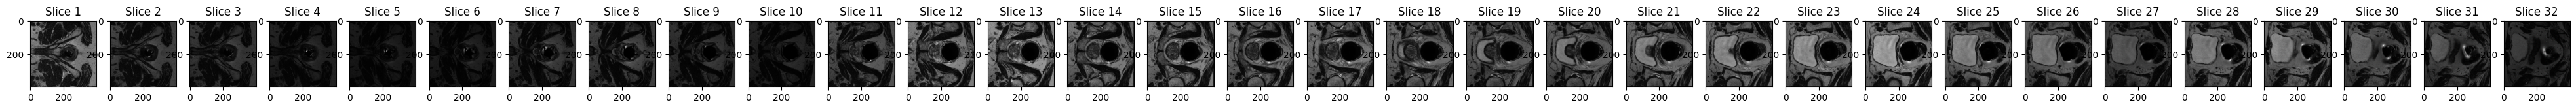

In [ ]:
# Showing Images
num_slices = test_images[6].shape[2]
dimensions = test_images[6].shape[:2]

print(f'The dimension of each slice is: {dimensions}')
fig, axes = plt.subplots(1, num_slices, figsize=(50, 50))
print(num_slices)

for i in range(num_slices):
    axes[i].imshow(test_images[6][:, :, i], cmap='gray')
    axes[i].set_title(f'Slice {i + 1}')

plt.show()

32


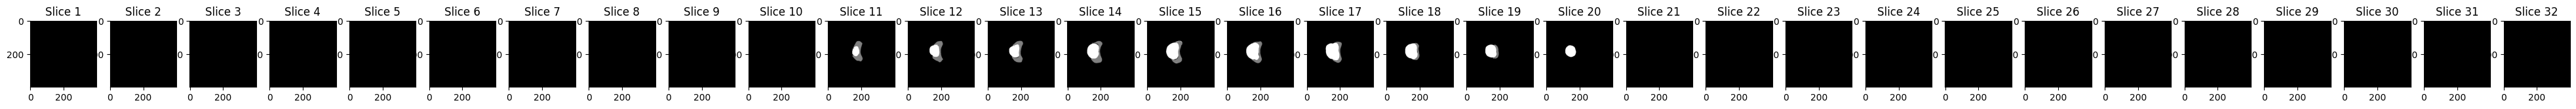

In [ ]:
# Showing Segmentation
num_slices = test_masks[6].shape[2]
fig, axes = plt.subplots(1, num_slices, figsize=(50, 50))
print(num_slices)

for i in range(num_slices):
    axes[i].imshow(test_masks[6][:, :, i], cmap='gray')
    axes[i].set_title(f'Slice {i + 1}')

plt.show()

In [ ]:
def make_prostatemask(image, display=False):
    img = image.copy()
    row_size= img.shape[0]
    col_size = img.shape[1]

    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the prostate
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)]
    mean = np.mean(middle)
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean

    # Using Kmeans to separate foreground (soft tissue / bone) and background (prostate/air)

    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the prostate.
    # We don't want to accidentally clip the prostate.

    eroded = morphology.erosion(thresh_img,np.ones([4,4,4]))
    dilation = morphology.dilation(eroded,np.ones([8,8,8]))

    dilation = dilation[:,:,0]
    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []

    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the prostate is left, we do another large dilation
    #  in order to fill in and out the prostate mask
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)

    size = 10000 # maximum isolated area (in pixels) that will be removed

    mask = morphology.dilation(mask,np.ones([15,15])) # one last dilation

    arr = mask > 0
    cleaned = morphology.remove_small_objects(arr, size)
    mask = morphology.remove_small_holes(cleaned, size)


    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*image[:,:,0], cmap='gray')
        ax[2, 1].axis('off')

        plt.show()
    return mask*image[:,:,0], mask

def watershedmask(img, display = False):
  image = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  image_display = image.copy()

  row_size= img.shape[0]
  col_size = img.shape[1]

  blur_image = cv2.medianBlur(image, 7)

  gray_image = cv2.cvtColor(blur_image, cv2.COLOR_RGB2GRAY)
  mean = np.mean(gray_image)
  std = np.std(gray_image)
  # plt.imshow(gray_image, cmap='gray')

  ret, sep_thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  sep_thresh = cv2.bitwise_not(sep_thresh)


  kernel_erosion = np.ones((6,6), np.uint8)
  kernel_dilation = np.ones((8,8), np.uint8)

  eroded = cv2.morphologyEx(sep_thresh, cv2.MORPH_ERODE, kernel_erosion, iterations=2)
  dilated = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel_dilation, iterations=2)

  temp = morphology.remove_small_holes(dilated, 1000)
  dilated = img_as_ubyte(temp)

  dist_transform = cv2.distanceTransform(dilated, cv2.DIST_L2, 5)

  ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(),255,0)
  sure_fg = np.uint8(sure_fg)

  unknown = np.subtract(dilated, sure_fg)

  ret, markers = cv2.connectedComponents(sure_fg)
  markers = markers + 1
  markers[unknown == 255] = 0

  markers = cv2.watershed(image, markers)

  labels = measure.label(markers) # Different labels are displayed in different colors
  label_vals = np.unique(labels)
  regions = measure.regionprops(labels)
  good_labels = []

  for prop in regions:
      B = prop.bbox
      if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
          good_labels.append(prop.label)

  mask = np.ndarray([row_size,col_size],dtype=np.int8)
  mask[:] = 0

  for N in good_labels:
    mask = mask + np.where(labels==N,1,0)

  mask = morphology.dilation(mask,np.ones([20,20])) # one last dilation


  if (display):
    fig, ax = plt.subplots(5, 2, figsize=[12, 20])
    ax[0, 0].set_title("Original")
    ax[0, 0].imshow(prostate_image, cmap='gray')
    ax[0, 0].axis('off')
    ax[0, 1].set_title("Blured image")
    ax[0, 1].imshow(blur_image, cmap='gray')
    ax[0, 1].axis('off')
    ax[1, 0].set_title("Thresholded")
    ax[1, 0].imshow(sep_thresh, cmap='gray')
    ax[1, 0].axis('off')
    ax[1, 1].set_title("After erosion and dilation")
    ax[1, 1].imshow(dilated, cmap='gray')
    ax[1, 1].axis('off')
    ax[2, 0].set_title("Distance Transform")
    ax[2, 0].imshow(dist_transform, cmap='gray')
    ax[2, 0].axis('off')
    ax[2, 1].set_title("Sure foreground")
    ax[2, 1].imshow(sure_fg)
    ax[2, 1].axis('off')
    ax[3, 0].set_title("Unknown Area")
    ax[3, 0].imshow(unknown)
    ax[3, 0].axis('off')
    ax[3, 1].set_title("Watershed Markers")
    ax[3, 1].imshow(markers, cmap='gray')
    ax[3, 1].axis('off')
    ax[4, 0].set_title("Final Mask")
    ax[4, 0].imshow(mask, cmap='gray')
    ax[4, 0].axis('off')
    ax[4, 1].set_title("Applied Mask")
    ax[4, 1].imshow(mask*prostate_image, cmap='gray')
    ax[4, 1].axis('off')

    plt.show()
  return mask*prostate_image, mask



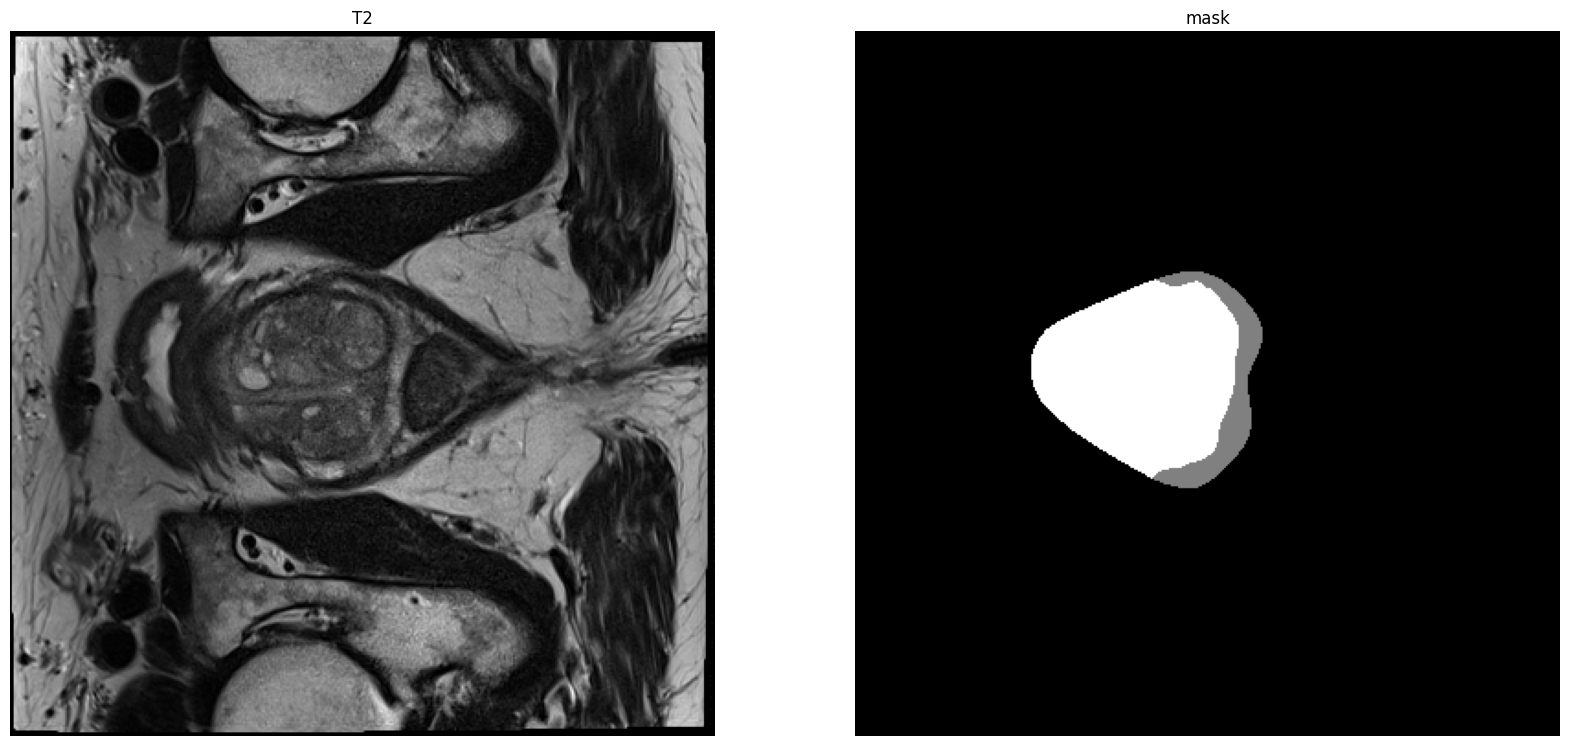

In [ ]:
prostate_image = test_images[2][:, :, 10]
prostate_mask = test_masks[2][:, :, 10]

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].set_title("T2")
ax[0].imshow(prostate_image, cmap='gray')
ax[0].axis('off')

ax[1].set_title("mask")
ax[1].imshow(prostate_mask, cmap='gray')
ax[1].axis('off')

plt.show()

In [ ]:
print(f'The shape of the image is: {prostate_image.shape}')
print(f'The shape of the mask is: {prostate_mask.shape}')

The shape of the image is: (384, 384)
The shape of the mask is: (384, 384)


(384, 384)


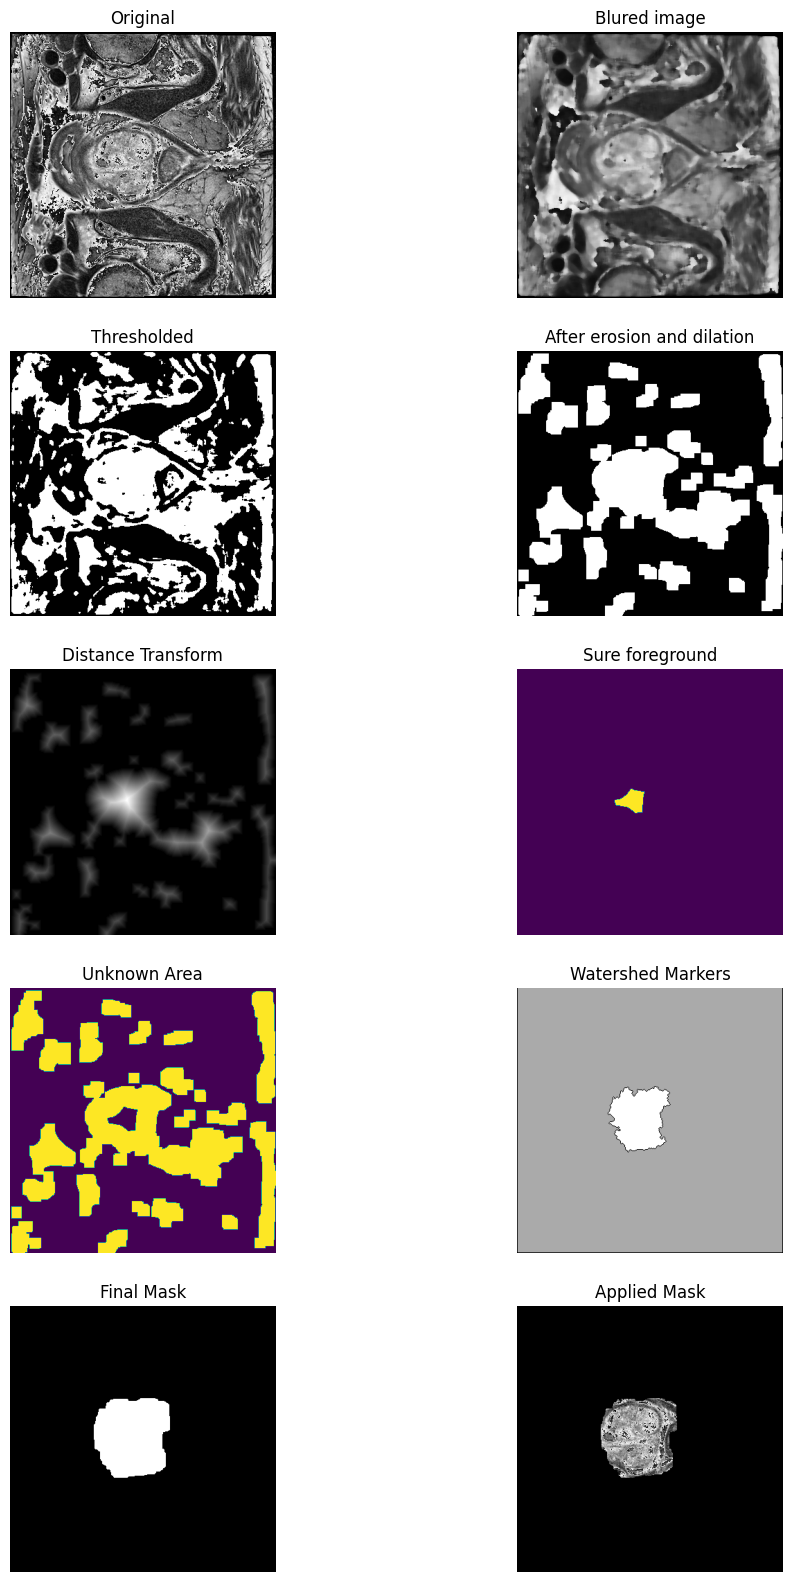

In [ ]:
prostate_image = prostate_image.astype(np.uint8)
print(prostate_image.shape)

t2_masked_ws, ws_mask = watershedmask(prostate_image, display=True)

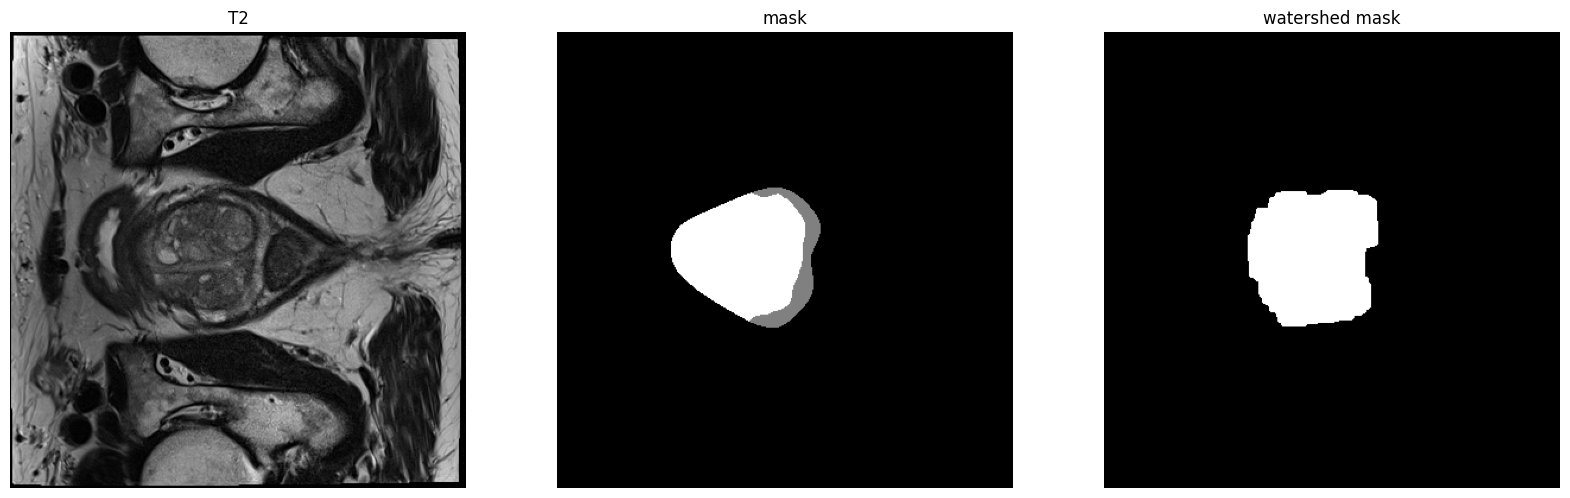

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].set_title("T2")
ax[0].imshow(prostate_image, cmap='gray')
ax[0].axis('off')

ax[1].set_title("mask")
ax[1].imshow(prostate_mask, cmap='gray')
ax[1].axis('off')

ax[2].set_title("watershed mask")
ax[2].imshow(ws_mask, cmap='gray')
ax[2].axis('off')

plt.show()